## 2d kernel

In [1]:
from pathlib import Path
import re
import pandas as pd
from typing import Union, List, Optional

def _to_number(s: str) -> Union[int, float]:
    """Cast '256.0' → 256 (int) and '256.5' → 256.5 (float)."""
    if "." in s:
        as_float = float(s)
        return int(as_float) if as_float.is_integer() else as_float
    return int(s)

def _parse_cu_mask(raw: str, *, to_int: bool) -> Optional[Union[int, float, str]]:
    """Handle hex/dec/nan mask; return int, float('nan'), or raw string."""
    if raw.lower() == "nan":
        return float("nan") if to_int else raw
    if raw.startswith("0x"):
        return int(raw, 16) if to_int else raw
    return _to_number(raw) if to_int else raw

def load_kernel_traces(
    directory: Path | str = ".",
    *,
    as_concat: bool = True,
    cu_mask_as_int: bool = False,
) -> Union[pd.DataFrame, List[pd.DataFrame]]:
    directory = Path(directory)
    trace_files = sorted(directory.glob("*_kernel_trace.csv"))


    phase_choices = r"(?P<mode>prefill_and_decode|prefill|decode)"

    pattern = re.compile(
        rf"^standalone_attn_{phase_choices}_"        # ← exact phase
        r"(?P<prefill_batch>\d+(?:\.\d+)?)_"
        r"(?P<prefill_len>\d+(?:\.\d+)?)_"
        r"(?P<decode_batch_size>\d+(?:\.\d+)?)_"
        r"(?P<decode_len>\d+(?:\.\d+)?)_"
        r"(?P<cu_mask>0x[0-9A-Fa-f]+|\d+(?:\.\d+)?|nan)"
        r"_kernel_trace\.csv$"
    )



    frames = []
    for f in trace_files:
        m = pattern.match(f.name)
        if not m:
            print(f"⚠️  Skipping file that doesn’t match pattern: {f.name}")
            continue

        df = pd.read_csv(f)
        df["mode"] = m["mode"]

        # numeric pieces
        df["prefill_batch"]     = _to_number(m["prefill_batch"])
        df["prefill_len"]       = _to_number(m["prefill_len"])
        df["decode_batch_size"] = _to_number(m["decode_batch_size"])
        df["decode_len"]        = _to_number(m["decode_len"])

        # mask and phase
        df["cu_mask"] = _parse_cu_mask(m["cu_mask"], to_int=cu_mask_as_int)
        df["source_file"] = f.name

        frames.append(df)

    if not frames:
        raise FileNotFoundError("No *_kernel_trace.csv files matched the new pattern")

    return pd.concat(frames, ignore_index=True) if as_concat else frames


if __name__ == "__main__":
    kernel_df = load_kernel_traces(".", cu_mask_as_int=True)
    print(f"Loaded {kernel_df.source_file.nunique()} files; shape = {kernel_df.shape}")


⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_16.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_8.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_2048.0_1.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_2048.0_16.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_2048.0_8.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_256.0_1.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: s

In [17]:
kernel_df['cu_mask']=kernel_df['cu_mask'].fillna(304)

In [18]:
mask = kernel_df["Kernel_Name"].str.startswith("kernel_unified_attention", na=False)
attn_df = kernel_df[mask]

In [19]:
attn_df['mode'].value_counts()

mode
prefill_and_decode    17060
decode                 8530
prefill                8530
Name: count, dtype: int64

In [20]:
## Ensuring Corerct number of rows and in correct order

import numpy as np
import pandas as pd

# ---------------------------------------------------------------------
# 0)  Filter to attention kernels, keep original order marker
# ---------------------------------------------------------------------
comb_cols = [
    "mode",
    "prefill_batch",
    "prefill_len",
    "decode_batch_size",
    "decode_len",
    "cu_mask",
]

attn_df = (
    kernel_df[kernel_df["Kernel_Name"]
              .str.startswith("kernel_unified_attention", na=False)]
    .copy()
    .reset_index(drop=False)
    .rename(columns={"index": "_orig"})
)

# ---------------------------------------------------------------------
# 1)  Check row-count rule: 5 for prefill/decode, 10 for prefill_and_decode
# ---------------------------------------------------------------------
size_df = (
    attn_df.groupby(comb_cols, sort=False)
           .size()
           .rename("actual")
           .reset_index()
)

# expected size depends on mode
size_df["expected"] = np.where(
    size_df["mode"] == "prefill_and_decode",
    10,
    5,
)

violations = size_df.query("actual != expected")
if not violations.empty:
    raise ValueError(
        "Row-count check failed for these combinations:\n"
        f"{violations.to_string(index=False)}"
    )

# ---------------------------------------------------------------------
# 2)  Re-assemble so each combination’s rows stay together
# ---------------------------------------------------------------------
ordered_blocks = (
    attn_df
    .groupby(comb_cols, sort=False, as_index=False)   # preserve first-seen order
    .apply(lambda g: g.sort_values("_orig"))          # keep original row order
)

ordered_attn_df = (
    ordered_blocks
    .droplevel(0)
    .reset_index(drop=True)
)

print(f"Final shape: {ordered_attn_df.shape}")
# ordered_attn_df now has blocks of 5 or 10 rows in the right order


Final shape: (34120, 26)


/tmp/ipykernel_793115/2988780790.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("_orig"))          # keep original row order


In [21]:
ordered_attn_df["duration_us"] = (
    ordered_attn_df["End_Timestamp"] - ordered_attn_df["Start_Timestamp"]
) / 1_000

In [22]:
ordered_attn_df

,_orig,Kind,Agent_Id,Queue_Id,Thread_Id,Dispatch_Id,Kernel_Id,Kernel_Name,Correlation_Id,Start_Timestamp,...,Grid_Size_Y,Grid_Size_Z,mode,prefill_batch,prefill_len,decode_batch_size,decode_len,cu_mask,source_file,duration_us
0,42,KERNEL_DISPATCH,7,2,245135,43,273,kernel_unified_attention_2d,43,489194145265922,...,8,1,decode,1,1024,128,1024,128.0,standalone_attn_decode_1.0_1024.0_128.0_1024.0...,567.298
1,43,KERNEL_DISPATCH,7,2,245135,44,273,kernel_unified_attention_2d,44,489194146109771,...,8,1,decode,1,1024,128,1024,128.0,standalone_attn_decode_1.0_1024.0_128.0_1024.0...,564.452
2,44,KERNEL_DISPATCH,7,2,245135,45,273,kernel_unified_attention_2d,45,489194146808450,...,8,1,decode,1,1024,128,1024,128.0,standalone_attn_decode_1.0_1024.0_128.0_1024.0...,564.852
3,45,KERNEL_DISPATCH,7,2,245135,46,273,kernel_unified_attention_2d,46,489194147486962,...,8,1,decode,1,1024,128,1024,128.0,standalone_attn_decode_1.0_1024.0_128.0_1024.0...,564.852
4,46,KERNEL_DISPATCH,7,2,245135,47,273,kernel_unified_attention_2d,47,489194148158859,...,8,1,decode,1,1024,128,1024,128.0,standalone_attn_decode_1.0_1024.0_128.0_1024.0...,565.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34115,249071,KERNEL_DISPATCH,7,3,475754,48,274,kernel_unified_attention_2d,48,527618956063823,...,8,1,prefill_and_decode,8,512,64,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_6...,1752.048
34116,249072,KERNEL_DISPATCH,7,2,475754,49,273,kernel_unified_attention_2d,49,527618957938231,...,8,1,prefill_and_decode,8,512,64,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_6...,63.907
34117,249073,KERNEL_DISPATCH,7,3,475754,50,274,kernel_unified_attention_2d,50,527618958028438,...,8,1,prefill_and_decode,8,512,64,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_6...,1743.669
34118,249074,KERNEL_DISPATCH,7,2,475754,51,273,kernel_unified_attention_2d,51,527618959889496,...,8,1,prefill_and_decode,8,512,64,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_6...,66.031


In [23]:
ordered_attn_df.to_csv('ordered_attn_df.csv')

In [ ]:
def _summarise_group(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("_orig")                # keep original chronological order
    mode = g["mode"].iat[0]

    # initialise with NaN – will be overwritten as needed
    out = {
        "avg_duration_us":          pd.NA,
        "avg_decode_duration_us":   pd.NA,
        "avg_prefill_duration_us":  pd.NA,
    }
    dur = g["duration_us"]
    decode_vals  = dur[g["Queue_Id"] == 2]
    prefill_vals = dur[g["Queue_Id"] == 1]

    if mode in {"prefill", "decode"}:
        out["avg_duration_us"] = g["duration_us"].iloc[-3:].mean()
    else:      
        out["avg_decode_duration_us"]  = decode_vals.iloc[-3:].mean()
        out["avg_prefill_duration_us"] = prefill_vals.iloc[-3:].mean()
        
        
        # a=sub.iloc[[0, 2, 4]]["duration_us"].mean()
        # b=sub.iloc[[1, 3, 5]]["duration_us"].mean()
        # out["avg_decode_duration_us"]  = min(a,b)
        # out["avg_prefill_duration_us"] = max(a,b)

    return pd.Series(out)


summary_df = (
    ordered_attn_df
    .groupby(
        ["mode","prefill_batch","prefill_len","decode_batch_size","decode_len","cu_mask"],
        sort=False,
    )
    .apply(_summarise_group)
    .reset_index()
)


# ── 3. build summary – keep keys as columns, THEN reset_index ──────────────────
summary_df = (
    ordered_attn_df
    .groupby(comb_cols, sort=False)      # as_index=True by default
    .apply(_summarise_group)
    .reset_index()                       # keys become real columns
)

print(summary_df.head())

/tmp/ipykernel_793115/3359361124.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_summarise_group)


     mode  prefill_batch  prefill_len  decode_batch_size  decode_len  cu_mask  \
0  decode              1         1024                128        1024    128.0   
1  decode              1         1024                128        1024     32.0   
2  decode              1         1024                128        1024     64.0   
3  decode              1         1024                128        1024    304.0   
4  decode              1         1024                128        2048    128.0   

  avg_duration_us avg_decode_duration_us avg_prefill_duration_us  
0      564.932333                   <NA>                    <NA>  
1        2478.658                   <NA>                    <NA>  
2     1255.285667                   <NA>                    <NA>  
3      232.732667                   <NA>                    <NA>  
4        1110.875                   <NA>                    <NA>  


/tmp/ipykernel_793115/3359361124.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_summarise_group)


In [8]:
summary_df.tail()

,mode,prefill_batch,prefill_len,decode_batch_size,decode_len,cu_mask,avg_duration_us,avg_decode_duration_us,avg_prefill_duration_us
3841,prefill_and_decode,8,512,64,4096,32.0,<NA>,4941.907,2004.706667
3842,prefill_and_decode,8,512,64,4096,64.0,<NA>,2460.657333,2197.534667
3843,prefill_and_decode,8,512,64,512,128.0,<NA>,157.654,3016.208667
3844,prefill_and_decode,8,512,64,512,32.0,<NA>,714.715333,1903.221333
3845,prefill_and_decode,8,512,64,512,64.0,<NA>,352.152,2162.601333


In [9]:
summary_df[summary_df['mode']=='prefill']

,mode,prefill_batch,prefill_len,decode_batch_size,decode_len,cu_mask,avg_duration_us,avg_decode_duration_us,avg_prefill_duration_us
1282,prefill,1,1024,128,1024,128.0,1460.928667,<NA>,<NA>
1283,prefill,1,1024,128,1024,32.0,961.346667,<NA>,<NA>
1284,prefill,1,1024,128,1024,64.0,1067.883,<NA>,<NA>
1285,prefill,1,1024,128,2048,128.0,1467.21,<NA>,<NA>
1286,prefill,1,1024,128,2048,32.0,955.519667,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
2559,prefill,8,512,64,4096,32.0,1894.254,<NA>,<NA>
2560,prefill,8,512,64,4096,64.0,2152.685333,<NA>,<NA>
2561,prefill,8,512,64,512,128.0,2998.488333,<NA>,<NA>
2562,prefill,8,512,64,512,32.0,1901.751333,<NA>,<NA>


In [25]:
summary_df.to_csv('result.csv')

In [26]:
df_res=pd.read_csv('result.csv')
df_res

,Unnamed: 0,mode,prefill_batch,prefill_len,decode_batch_size,decode_len,cu_mask,avg_duration_us,avg_decode_duration_us,avg_prefill_duration_us
0,0,decode,1,1024,128,1024,128.0,564.932333,NaN,NaN
1,1,decode,1,1024,128,1024,32.0,2478.658000,NaN,NaN
2,2,decode,1,1024,128,1024,64.0,1255.285667,NaN,NaN
3,3,decode,1,1024,128,1024,304.0,232.732667,NaN,NaN
4,4,decode,1,1024,128,2048,128.0,1110.875000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5113,5113,prefill_and_decode,8,512,64,4096,304.0,NaN,575.036000,2085.532333
5114,5114,prefill_and_decode,8,512,64,512,128.0,NaN,157.654000,3016.208667
5115,5115,prefill_and_decode,8,512,64,512,32.0,NaN,714.715333,1903.221333
5116,5116,prefill_and_decode,8,512,64,512,64.0,NaN,352.152000,2162.601333


In [27]:
df_exp=pd.read_csv("../Decode Mask Experiment.csv")
df_exp

,Prefill Len,Prefill Batch,Prefill Tokens,Decode batch size,Decode len,CU mask,Prefill time in isolation,Prefill time with interference,Serial Prefill time,Slowdown in prefill (H-G),Decode time in isolation,Decode Time with interference,Serial Decode Time,Slowdown in decode(L-K),Total Serial Time,Total Time with Interference,Overlap,Unnamed: 17,Unnamed: 18,Slowdown in decode ()
0,256,1,256,32,256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,256,4,1024,32,256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,256,8,2048,32,256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,256,16,4096,32,256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,256,32,8192,32,256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2538,2048,1,2048,512,4096,288.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2539,2048,4,8192,512,4096,288.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2540,2048,8,16384,512,4096,288.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2541,4096,1,4096,512,4096,288.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
import pandas as pd

# ── 1. load the two CSVs ──────────────────────────────────────────────────────
df_res = pd.read_csv("result.csv")                             # has mode + avg_* cols
df_exp = pd.read_csv("../Decode Mask Experiment.csv")

# ── 2. normalize the experiment sheet’s key names ────────────────────────────
df_exp = df_exp.rename(columns={
    "Prefill Len":       "prefill_len",
    "Prefill Batch":     "prefill_batch",
    "Decode batch size": "decode_batch_size",
    "Decode len":        "decode_len",
    "CU mask":           "cu_mask",
})
comb_cols = ["prefill_batch", "prefill_len", "decode_batch_size", "decode_len", "cu_mask"]
df_exp[comb_cols] = df_exp[comb_cols].apply(pd.to_numeric, errors="ignore")

# ── 3. carve out three summaries ───────────────────────────────────────────────
# 3a) prefill-only → Prefill time in isolation
df_pref = (
    df_res[df_res["mode"] == "prefill"]
    .loc[:, comb_cols + ["avg_duration_us"]]
    .rename(columns={"avg_duration_us": "Prefill time in isolation"})
)

# 3b) decode-only → Decode time in isolation
df_dec = (
    df_res[df_res["mode"] == "decode"]
    .loc[:, comb_cols + ["avg_duration_us"]]
    .rename(columns={"avg_duration_us": "Decode time in isolation"})
)

# 3c) prefill_and_decode → interference columns
df_both = (
    df_res[df_res["mode"] == "prefill_and_decode"]
    .loc[:, comb_cols + ["avg_prefill_duration_us", "avg_decode_duration_us"]]
    .rename(columns={
        "avg_prefill_duration_us": "Prefill time with interference",
        "avg_decode_duration_us":  "Decode Time with interference"
    })
)

# ── 4. stitch them into one wide summary ──────────────────────────────────────
df_summary = (
    df_pref
    .merge(df_dec, on=comb_cols, how="outer")
    .merge(df_both, on=comb_cols, how="outer")
)

# ── 5. merge wide summary into your experiment sheet ──────────────────────────
df_filled = df_exp.merge(df_summary, on=comb_cols, how="left")

# ── 6. save the filled sheet ─────────────────────────────────────────────────
df_filled.to_csv("Decode Mask Experiment - final.csv", index=False)
print("✅ Wrote Decode Mask Experiment - final.csv")


✅ Wrote Decode Mask Experiment - final.csv


/tmp/ipykernel_793115/2943497734.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_exp[comb_cols] = df_exp[comb_cols].apply(pd.to_numeric, errors="ignore")


In [14]:
df_filled[:20]

,prefill_len,prefill_batch,Prefill Tokens,decode_batch_size,decode_len,cu_mask,Prefill time in isolation_x,Prefill time with interference_x,Serial Prefill time,Slowdown in prefill (H-G),...,Total Serial Time,Total Time with Interference,Overlap,Unnamed: 17,Unnamed: 18,Slowdown in decode (),Prefill time in isolation_y,Decode time in isolation_y,Prefill time with interference_y,Decode Time with interference_y
0,256,1,256,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,256,4,1024,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,256,8,2048,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,256,16,4096,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,256,32,8192,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,512,1,512,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,512,4,2048,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,512,8,4096,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,512,16,8192,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1024,1,1024,32,256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_filled['Slowdown in Prefill']=df_filled['Prefill time with interference_y']-df_filled['Prefill time in isolation_y']

In [17]:
df_filled['Slowdown in Decode']=df_filled['Decode Time with interference_y']-df_filled['Decode time in isolation_y']

## 3d and 2d

In [2]:
from pathlib import Path
import re
import pandas as pd
from typing import Union, List, Optional

def _to_number(s: str) -> Union[int, float]:
    """Cast '256.0' → 256 (int) and '256.5' → 256.5 (float)."""
    if "." in s:
        as_float = float(s)
        return int(as_float) if as_float.is_integer() else as_float
    return int(s)

def _parse_cu_mask(raw: str, *, to_int: bool) -> Optional[Union[int, float, str]]:
    """Handle hex/dec/nan mask; return int, float('nan'), or raw string."""
    if raw.lower() == "nan":
        return float("nan") if to_int else raw
    if raw.startswith("0x"):
        return int(raw, 16) if to_int else raw
    return _to_number(raw) if to_int else raw

def load_kernel_traces(
    directory: Path | str = ".",
    *,
    as_concat: bool = True,
    cu_mask_as_int: bool = False,
) -> Union[pd.DataFrame, List[pd.DataFrame]]:
    directory = Path(directory)
    trace_files = sorted(directory.glob("*_kernel_trace.csv"))


    phase_choices = r"(?P<mode>prefill_and_decode|prefill|decode)"

    pattern = re.compile(
        rf"^standalone_attn_{phase_choices}_"        # ← exact phase
        r"(?P<prefill_batch>\d+(?:\.\d+)?)_"
        r"(?P<prefill_len>\d+(?:\.\d+)?)_"
        r"(?P<decode_batch_size>\d+(?:\.\d+)?)_"
        r"(?P<decode_len>\d+(?:\.\d+)?)_"
        r"(?P<cu_mask>0x[0-9A-Fa-f]+|\d+(?:\.\d+)?|nan)"
        r"_kernel_trace\.csv$"
    )



    frames = []
    for f in trace_files:
        m = pattern.match(f.name)
        if not m:
            print(f"⚠️  Skipping file that doesn’t match pattern: {f.name}")
            continue

        df = pd.read_csv(f)
        df["mode"] = m["mode"]

        # numeric pieces
        df["prefill_batch"]     = _to_number(m["prefill_batch"])
        df["prefill_len"]       = _to_number(m["prefill_len"])
        df["decode_batch_size"] = _to_number(m["decode_batch_size"])
        df["decode_len"]        = _to_number(m["decode_len"])

        # mask and phase
        df["cu_mask"] = _parse_cu_mask(m["cu_mask"], to_int=cu_mask_as_int)
        df["source_file"] = f.name

        frames.append(df)

    if not frames:
        raise FileNotFoundError("No *_kernel_trace.csv files matched the new pattern")

    return pd.concat(frames, ignore_index=True) if as_concat else frames


if __name__ == "__main__":
    kernel_df = load_kernel_traces(".", cu_mask_as_int=True)
    print(f"Loaded {kernel_df.source_file.nunique()} files; shape = {kernel_df.shape}")


⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_16.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_8.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_2048.0_1.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_2048.0_16.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_2048.0_8.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_256.0_1.0_256.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: s

In [3]:
kernel_df['cu_mask']=kernel_df['cu_mask'].fillna(304)

In [17]:
mask = kernel_df["Kernel_Name"].str.startswith(
    ("kernel_unified_attention", "reduce_segment"),
    na=False
)
attn_df = kernel_df[mask]


In [18]:
attn_df

,Kind,Agent_Id,Queue_Id,Thread_Id,Dispatch_Id,Kernel_Id,Kernel_Name,Correlation_Id,Start_Timestamp,End_Timestamp,...,Grid_Size_X,Grid_Size_Y,Grid_Size_Z,mode,prefill_batch,prefill_len,decode_batch_size,decode_len,cu_mask,source_file
42,KERNEL_DISPATCH,8,2,1474556,43,273,kernel_unified_attention_3d,43,613177192867817,613177192879764,...,256,8,16,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...
43,KERNEL_DISPATCH,8,2,1474556,44,274,reduce_segments,44,613177789132211,613177789138465,...,256,64,1,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...
44,KERNEL_DISPATCH,8,2,1474556,45,273,kernel_unified_attention_3d,45,613177805428959,613177805440104,...,256,8,16,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...
45,KERNEL_DISPATCH,8,2,1474556,46,274,reduce_segments,46,613177805508902,613177805513192,...,256,64,1,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...
46,KERNEL_DISPATCH,8,2,1474556,47,273,kernel_unified_attention_3d,47,613177805668427,613177805678329,...,256,8,16,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564052,KERNEL_DISPATCH,8,2,1855316,53,274,reduce_segments,53,633613402977313,633613402982165,...,2048,64,1,prefill_and_decode,8,512,8,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_8...
564053,KERNEL_DISPATCH,8,3,1855316,54,275,kernel_unified_attention_2d,54,633613403077222,633613404797678,...,526336,8,1,prefill_and_decode,8,512,8,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_8...
564054,KERNEL_DISPATCH,8,2,1855316,55,273,kernel_unified_attention_3d,55,633613404932266,633613404952192,...,3072,8,16,prefill_and_decode,8,512,8,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_8...
564055,KERNEL_DISPATCH,8,2,1855316,56,274,reduce_segments,56,633613404987312,633613404992003,...,2048,64,1,prefill_and_decode,8,512,8,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_8...


In [19]:
## Ensuring Corerct number of rows and in correct order

import numpy as np
import pandas as pd

# ---------------------------------------------------------------------
# 0)  Filter to attention kernels, keep original order marker
# ---------------------------------------------------------------------
comb_cols = [
    "mode",
    "prefill_batch",
    "prefill_len",
    "decode_batch_size",
    "decode_len",
    "cu_mask",
]

attn_df = attn_df.copy().reset_index(drop=False).rename(columns={"index": "_orig"})


# ---------------------------------------------------------------------
# 2)  Re-assemble so each combination’s rows stay together
# ---------------------------------------------------------------------
ordered_blocks = (
    attn_df
    .groupby(comb_cols, sort=False, as_index=False)   # preserve first-seen order
    .apply(lambda g: g.sort_values("_orig"))          # keep original row order
)

ordered_attn_df = (
    ordered_blocks
    .droplevel(0)
    .reset_index(drop=True)
)

print(f"Final shape: {ordered_attn_df.shape}")
# ordered_attn_df now has blocks of 5 or 10 rows in the right order


Final shape: (83115, 26)


/tmp/ipykernel_6918/4256185850.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("_orig"))          # keep original row order


In [20]:
ordered_attn_df["duration_us"] = (
    ordered_attn_df["End_Timestamp"] - ordered_attn_df["Start_Timestamp"]
) / 1_000

In [21]:
ordered_attn_df

,_orig,Kind,Agent_Id,Queue_Id,Thread_Id,Dispatch_Id,Kernel_Id,Kernel_Name,Correlation_Id,Start_Timestamp,...,Grid_Size_Y,Grid_Size_Z,mode,prefill_batch,prefill_len,decode_batch_size,decode_len,cu_mask,source_file,duration_us
0,42,KERNEL_DISPATCH,8,2,1474556,43,273,kernel_unified_attention_3d,43,613177192867817,...,8,16,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...,11.947
1,43,KERNEL_DISPATCH,8,2,1474556,44,274,reduce_segments,44,613177789132211,...,64,1,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...,6.254
2,44,KERNEL_DISPATCH,8,2,1474556,45,273,kernel_unified_attention_3d,45,613177805428959,...,8,16,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...,11.145
3,45,KERNEL_DISPATCH,8,2,1474556,46,274,reduce_segments,46,613177805508902,...,64,1,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...,4.290
4,46,KERNEL_DISPATCH,8,2,1474556,47,273,kernel_unified_attention_3d,47,613177805668427,...,8,16,decode,1,1024,1,1024,128.0,standalone_attn_decode_1.0_1024.0_1.0_1024.0_1...,9.902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83110,564052,KERNEL_DISPATCH,8,2,1855316,53,274,reduce_segments,53,633613402977313,...,64,1,prefill_and_decode,8,512,8,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_8...,4.852
83111,564053,KERNEL_DISPATCH,8,3,1855316,54,275,kernel_unified_attention_2d,54,633613403077222,...,8,1,prefill_and_decode,8,512,8,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_8...,1720.456
83112,564054,KERNEL_DISPATCH,8,2,1855316,55,273,kernel_unified_attention_3d,55,633613404932266,...,8,16,prefill_and_decode,8,512,8,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_8...,19.926
83113,564055,KERNEL_DISPATCH,8,2,1855316,56,274,reduce_segments,56,633613404987312,...,64,1,prefill_and_decode,8,512,8,512,304.0,standalone_attn_prefill_and_decode_8.0_512.0_8...,4.691


In [ ]:
import pandas as pd
from pandas import NA

def _summarise_group(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("_orig")          # chronological
    mode = g["mode"].iat[0]

    # container for results
    out = {
        "avg_duration_2d_us":              NA,
        "avg_duration_3d_us":              NA,
        "avg_duration_reduce_segment_us":  NA,
        "avg_decode_duration_us":          NA,
        "avg_prefill_duration_us":         NA,
    }

    # handy slices (DataFrames, not Series)
    attn_2d = g[g["Kernel_Name"] == "kernel_unified_attention_2d"]
    attn_3d = g[g["Kernel_Name"] == "kernel_unified_attention_3d"]
    attn_red = g[g["Kernel_Name"] == "reduce_segments"]

    # --------------------------- PREFILL-ONLY ----------------------------
    if mode == "prefill":
        out["avg_prefill_duration_us"] = g["duration_us"].iloc[-3:].mean()

    # --------------------------- DECODE-ONLY -----------------------------
    elif mode == "decode":
        if not attn_2d.empty:                           # 2-D path
            out["avg_duration_2d_us"] = attn_2d["duration_us"].iloc[-3:].mean()
            out["avg_decode_duration_us"] = out["avg_duration_2d_us"]
        else:                                           # 3-D path + reduce
            if not attn_3d.empty:
                out["avg_duration_3d_us"] = attn_3d["duration_us"].iloc[-3:].mean()
            if not attn_red.empty:
                out["avg_duration_reduce_segment_us"] = (
                    attn_red["duration_us"].iloc[-3:].mean()
                )
            out["avg_decode_duration_us"] = (
                (out["avg_duration_3d_us"] or 0)
                + (out["avg_duration_reduce_segment_us"] or 0)
            )

    # -------------------- PREFILL _and_ DECODE (mixed) -------------------
    else:  
        if not attn_3d.empty:                            
            out["avg_duration_3d_us"] = attn_3d["duration_us"].iloc[-3:].mean()
            if not attn_red.empty:
                out["avg_duration_reduce_segment_us"] = (
                    attn_red["duration_us"].iloc[-3:].mean()
                )
            out["avg_decode_duration_us"] = (
                (out["avg_duration_3d_us"] or 0)
                + (out["avg_duration_reduce_segment_us"] or 0)
            )
            # prefill comes from 2-D kernels running on Queue-1
            pref = attn_2d[attn_2d["Queue_Id"] == 1]
            if not pref.empty:
                out["avg_prefill_duration_us"] = pref["duration_us"].iloc[-3:].mean()
        else:                                            # all 2-D kernels
            dec  = attn_2d[attn_2d["Queue_Id"] == 2]
            pref = attn_2d[attn_2d["Queue_Id"] == 1]
            if not dec.empty:
                out["avg_decode_duration_us"]  = dec["duration_us"].iloc[-3:].mean()
            if not pref.empty:
                out["avg_prefill_duration_us"] = pref["duration_us"].iloc[-3:].mean()

    return pd.Series(out)


In [24]:

summary_df = (
    ordered_attn_df
    .groupby(
        ["mode","prefill_batch","prefill_len","decode_batch_size","decode_len","cu_mask"],
        sort=False,
    )
    .apply(_summarise_group)
    .reset_index()
)


# ── 3. build summary – keep keys as columns, THEN reset_index ──────────────────
summary_df = (
    ordered_attn_df
    .groupby(comb_cols, sort=False)      # as_index=True by default
    .apply(_summarise_group)
    .reset_index()                       # keys become real columns
)

print(summary_df.head())

/tmp/ipykernel_6918/699047138.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_summarise_group)


     mode  prefill_batch  prefill_len  decode_batch_size  decode_len  cu_mask  \
0  decode              1         1024                  1        1024    128.0   
1  decode              1         1024                  1        1024     32.0   
2  decode              1         1024                  1        1024     64.0   
3  decode              1         1024                  1        1024    304.0   
4  decode              1         1024                  1        2048    128.0   

  avg_duration_2d_us avg_duration_3d_us avg_duration_reduce_segment_us  \
0               <NA>           9.301333                          4.824   
1               <NA>              9.235                       5.198667   
2               <NA>           9.916333                       4.931667   
3               <NA>           9.448667                       4.944333   
4               <NA>             12.602                          4.437   

  avg_decode_duration_us avg_prefill_duration_us  
0              14

/tmp/ipykernel_6918/699047138.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_summarise_group)


In [ ]:
summary_df.to_csv("small_batch.csv")

In [28]:

key_cols = ["mode",
            "prefill_batch", "prefill_len",
            "decode_batch_size", "decode_len"]

value_cols = [
    "avg_duration_2d_us",
    "avg_duration_3d_us",
    "avg_duration_reduce_segment_us",
    "avg_decode_duration_us",
    "avg_prefill_duration_us",
]

  
baseline_df = (
    summary_df.loc[summary_df["cu_mask"] == 304,
                   key_cols + value_cols]
    .rename(columns={c: f"{c}_baseline" for c in value_cols})
)

In [29]:
summary_with_baseline = summary_df.merge(
    baseline_df,
    on=key_cols,       # match on everything *except* cu_mask
    how="left",
    suffixes=("", "_drop")   # avoid accidental name clashes
)


print(summary_with_baseline.head())

     mode  prefill_batch  prefill_len  decode_batch_size  decode_len  cu_mask  \
0  decode              1         1024                  1        1024    128.0   
1  decode              1         1024                  1        1024     32.0   
2  decode              1         1024                  1        1024     64.0   
3  decode              1         1024                  1        1024    304.0   
4  decode              1         1024                  1        2048    128.0   

  avg_duration_2d_us avg_duration_3d_us avg_duration_reduce_segment_us  \
0               <NA>           9.301333                          4.824   
1               <NA>              9.235                       5.198667   
2               <NA>           9.916333                       4.931667   
3               <NA>           9.448667                       4.944333   
4               <NA>             12.602                          4.437   

  avg_decode_duration_us avg_prefill_duration_us avg_duration_2d_us_

In [30]:
summary_with_baseline.to_csv("small_batch.csv")

## Effect of CU masking on decode 

In [1]:
from pathlib import Path
import re
import pandas as pd
from typing import Union, List, Optional

def _to_number(s: str) -> Union[int, float]:
    """Cast '256.0' → 256 (int) and '256.5' → 256.5 (float)."""
    if "." in s:
        as_float = float(s)
        return int(as_float) if as_float.is_integer() else as_float
    return int(s)

def _parse_cu_mask(raw: str, *, to_int: bool) -> Optional[Union[int, float, str]]:
    """Handle hex/dec/nan mask; return int, float('nan'), or raw string."""
    if raw.lower() == "nan":
        return float("nan") if to_int else raw
    if raw.startswith("0x"):
        return int(raw, 16) if to_int else raw
    return _to_number(raw) if to_int else raw

def load_kernel_traces(
    directory: Path | str = ".",
    *,
    as_concat: bool = True,
    cu_mask_as_int: bool = False,
) -> Union[pd.DataFrame, List[pd.DataFrame]]:
    directory = Path(directory)
    trace_files = sorted(directory.glob("*_kernel_trace.csv"))


    phase_choices = r"(?P<mode>decode|decode_)"

    pattern = re.compile(
        rf"^standalone_attn_{phase_choices}_"        # ← exact phase
        r"1(?:\.0)?_"
        r"2048(?:\.0)?_"
        r"(?P<decode_batch_size>\d+(?:\.\d+)?)_"
        r"(?P<decode_len>\d+(?:\.\d+)?)_"
        r"(?P<cu_mask>0x[0-9A-Fa-f]+|\d+(?:\.\d+)?|nan)"
        r"_kernel_trace\.csv$"
    )



    frames = []
    for f in trace_files:
        m = pattern.match(f.name)
        if not m:
            print(f"⚠️  Skipping file that doesn’t match pattern: {f.name}")
            continue

        df = pd.read_csv(f)
        df["mode"] = m["mode"]

        # numeric pieces
        df["prefill_batch"]     = 1
        df["prefill_len"]       = 2048
        df["decode_batch_size"] = _to_number(m["decode_batch_size"])
        df["decode_len"]        = _to_number(m["decode_len"])

        # mask and phase
        df["cu_mask"] = _parse_cu_mask(m["cu_mask"], to_int=cu_mask_as_int)
        df["source_file"] = f.name

        frames.append(df)

    if not frames:
        raise FileNotFoundError("No *_kernel_trace.csv files matched the new pattern")

    return pd.concat(frames, ignore_index=True) if as_concat else frames


if __name__ == "__main__":
    kernel_df = load_kernel_traces(".", cu_mask_as_int=True)
    print(f"Loaded {kernel_df.source_file.nunique()} files; shape = {kernel_df.shape}")


⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_128.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_32.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_32.0_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_64.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_nan_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_nan_tp8_unified_attention_2d_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_2048.0_128.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_2048.0_32.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: 

In [2]:
kernel_df['cu_mask']=kernel_df['cu_mask'].fillna(304)

In [3]:
kernel_df

,Kind,Agent_Id,Queue_Id,Thread_Id,Dispatch_Id,Kernel_Id,Kernel_Name,Correlation_Id,Start_Timestamp,End_Timestamp,...,Grid_Size_X,Grid_Size_Y,Grid_Size_Z,mode,prefill_batch,prefill_len,decode_batch_size,decode_len,cu_mask,source_file
0,KERNEL_DISPATCH,8,1,1481657,1,12,void at::native::(anonymous namespace)::distri...,1,613451495572781,613451495620691,...,622592,1,1,decode,1,2048,1,1024,128.0,standalone_attn_decode_1.0_2048.0_1.0_1024.0_1...
1,KERNEL_DISPATCH,8,1,1481657,2,12,void at::native::(anonymous namespace)::distri...,2,613451495846366,613451495888021,...,622592,1,1,decode,1,2048,1,1024,128.0,standalone_attn_decode_1.0_2048.0_1.0_1024.0_1...
2,KERNEL_DISPATCH,8,1,1481657,3,12,void at::native::(anonymous namespace)::distri...,3,613451495954734,613451495995748,...,622592,1,1,decode,1,2048,1,1024,128.0,standalone_attn_decode_1.0_2048.0_1.0_1024.0_1...
3,KERNEL_DISPATCH,8,1,1481657,4,12,void at::native::(anonymous namespace)::distri...,4,613451496000399,613451496005971,...,8192,1,1,decode,1,2048,1,1024,128.0,standalone_attn_decode_1.0_2048.0_1.0_1024.0_1...
4,KERNEL_DISPATCH,8,1,1481657,5,12,void at::native::(anonymous namespace)::distri...,5,613451496017438,613451496059093,...,622592,1,1,decode,1,2048,1,1024,128.0,standalone_attn_decode_1.0_2048.0_1.0_1024.0_1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15720,KERNEL_DISPATCH,2,2,370859,48,274,reduce_segments,48,718197282436801,718197282441813,...,2048,64,1,decode_,1,2048,8,8192,304.0,standalone_attn_decode__1_2048_8_8192_nan_kern...
15721,KERNEL_DISPATCH,2,2,370859,49,273,kernel_unified_attention_3d,49,718197282568623,718197282692547,...,3072,8,16,decode_,1,2048,8,8192,304.0,standalone_attn_decode__1_2048_8_8192_nan_kern...
15722,KERNEL_DISPATCH,2,2,370859,50,274,reduce_segments,50,718197282692547,718197282697237,...,2048,64,1,decode_,1,2048,8,8192,304.0,standalone_attn_decode__1_2048_8_8192_nan_kern...
15723,KERNEL_DISPATCH,2,2,370859,51,273,kernel_unified_attention_3d,51,718197282816991,718197282940875,...,3072,8,16,decode_,1,2048,8,8192,304.0,standalone_attn_decode__1_2048_8_8192_nan_kern...


In [4]:
mask = kernel_df["Kernel_Name"].str.startswith(
    ("kernel_unified_attention", "reduce_segment"),
    na=False
)
attn_df = kernel_df[mask]


In [5]:
## Ensuring Corerct number of rows and in correct order

import numpy as np
import pandas as pd

# ---------------------------------------------------------------------
# 0)  Filter to attention kernels, keep original order marker
# ---------------------------------------------------------------------
comb_cols = [
    "prefill_batch",
    "prefill_len",
    "decode_batch_size",
    "decode_len",
    "cu_mask",
]

attn_df = attn_df.copy().reset_index(drop=False).rename(columns={"index": "_orig"})


# ---------------------------------------------------------------------
# 2)  Re-assemble so each combination’s rows stay together
# ---------------------------------------------------------------------
ordered_blocks = (
    attn_df
    .groupby(comb_cols, sort=False, as_index=False)   # preserve first-seen order
    .apply(lambda g: g.sort_values("_orig"))          # keep original row order
)

ordered_attn_df = (
    ordered_blocks
    .droplevel(0)
    .reset_index(drop=True)
)

print(f"Final shape: {ordered_attn_df.shape}")
# ordered_attn_df now has blocks of 5 or 10 rows in the right order


Final shape: (2075, 26)


/tmp/ipykernel_991/4152903213.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("_orig"))          # keep original row order


In [6]:
ordered_attn_df["duration_us"] = (
    ordered_attn_df["End_Timestamp"] - ordered_attn_df["Start_Timestamp"]
) / 1_000

In [7]:
import pandas as pd
from pandas import NA

def _summarise_group(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("_orig")          # chronological
    mode = g["mode"].iat[0]

    # container for results
    out = {
        "avg_duration_2d_us":              NA,
        "avg_duration_3d_us":              NA,
        "avg_duration_reduce_segment_us":  NA,
        "avg_decode_duration_us":          NA,
    }

    # handy slices (DataFrames, not Series)
    attn_2d = g[g["Kernel_Name"] == "kernel_unified_attention_2d"]
    attn_3d = g[g["Kernel_Name"] == "kernel_unified_attention_3d"]
    attn_red = g[g["Kernel_Name"] == "reduce_segments"]

  
    if not attn_2d.empty:                           # 2-D path
        out["avg_duration_2d_us"] = attn_2d["duration_us"].iloc[-3:].mean()
        out["avg_decode_duration_us"] = out["avg_duration_2d_us"]
    else:                                           # 3-D path + reduce
        if not attn_3d.empty:
            out["avg_duration_3d_us"] = attn_3d["duration_us"].iloc[-3:].mean()
        if not attn_red.empty:
            out["avg_duration_reduce_segment_us"] = (
                attn_red["duration_us"].iloc[-3:].mean()
            )
        out["avg_decode_duration_us"] = (
            (out["avg_duration_3d_us"] or 0)
            + (out["avg_duration_reduce_segment_us"] or 0)
        )

    return pd.Series(out)


In [8]:

summary_df = (
    ordered_attn_df
    .groupby(
        ["prefill_batch","prefill_len","decode_batch_size","decode_len","cu_mask"],
        sort=False,
    )
    .apply(_summarise_group)
    .reset_index()
)


# ── 3. build summary – keep keys as columns, THEN reset_index ──────────────────
summary_df = (
    ordered_attn_df
    .groupby(comb_cols, sort=False)      # as_index=True by default
    .apply(_summarise_group)
    .reset_index()                       # keys become real columns
)

print(summary_df.head())

/tmp/ipykernel_991/3934525152.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_summarise_group)


   prefill_batch  prefill_len  decode_batch_size  decode_len  cu_mask  \
0              1         2048                  1        1024    128.0   
1              1         2048                  1        1024     32.0   
2              1         2048                  1        1024     64.0   
3              1         2048                  1        1024    304.0   
4              1         2048                  1        2048    128.0   

  avg_duration_2d_us avg_duration_3d_us avg_duration_reduce_segment_us  \
0               <NA>              9.702                       4.663667   
1               <NA>           9.074333                       4.837667   
2               <NA>           9.421667                          5.332   
3               <NA>           9.434333                       4.677333   
4               <NA>             13.043                       4.463333   

   avg_decode_duration_us  
0               14.365667  
1               13.912000  
2               14.753667  
3   

/tmp/ipykernel_991/3934525152.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_summarise_group)


In [9]:

key_cols = ["prefill_batch", "prefill_len",
            "decode_batch_size", "decode_len"]

value_cols = [
    "avg_duration_2d_us",
    "avg_duration_3d_us",
    "avg_duration_reduce_segment_us",
    "avg_decode_duration_us",
]

  
baseline_df = (
    summary_df.loc[summary_df["cu_mask"] == 304,
                   key_cols + value_cols]
    .rename(columns={c: f"{c}_baseline" for c in value_cols})
)

In [10]:
summary_with_baseline = summary_df.merge(
    baseline_df,
    on=key_cols,       # match on everything *except* cu_mask
    how="left",
    suffixes=("", "_drop")   # avoid accidental name clashes
)


print(summary_with_baseline.head())

   prefill_batch  prefill_len  decode_batch_size  decode_len  cu_mask  \
0              1         2048                  1        1024    128.0   
1              1         2048                  1        1024     32.0   
2              1         2048                  1        1024     64.0   
3              1         2048                  1        1024    304.0   
4              1         2048                  1        2048    128.0   

  avg_duration_2d_us avg_duration_3d_us avg_duration_reduce_segment_us  \
0               <NA>              9.702                       4.663667   
1               <NA>           9.074333                       4.837667   
2               <NA>           9.421667                          5.332   
3               <NA>           9.434333                       4.677333   
4               <NA>             13.043                       4.463333   

   avg_decode_duration_us avg_duration_2d_us_baseline  \
0               14.365667                        <NA>   
1 

In [11]:
summary_with_baseline.to_csv("decode isolation experiment.csv")

## 2d vs 3d study

In [15]:
from pathlib import Path
import re
import pandas as pd
from typing import Union, List, Optional

def _to_number(s: str) -> Union[int, float]:
    """Cast '256.0' → 256 (int) and '256.5' → 256.5 (float)."""
    if "." in s:
        as_float = float(s)
        return int(as_float) if as_float.is_integer() else as_float
    return int(s)

def _parse_cu_mask(raw: str, *, to_int: bool) -> Optional[Union[int, float, str]]:
    """Handle hex/dec/nan mask; return int, float('nan'), or raw string."""
    if raw.lower() == "nan":
        return float("nan") if to_int else raw
    if raw.startswith("0x"):
        return int(raw, 16) if to_int else raw
    return _to_number(raw) if to_int else raw

def load_kernel_traces(
    directory: Path | str = ".",
    *,
    as_concat: bool = True,
    cu_mask_as_int: bool = False,
) -> Union[pd.DataFrame, List[pd.DataFrame]]:
    directory = Path(directory)
    trace_files = sorted(directory.glob("*_kernel_trace.csv"))


    phase_choices = r"(?P<mode>prefill_and_decode|prefill|decode|prefill_and_decode_3d|prefill_3d|decode_3d)"

    kernel_choices = r"(?P<kernel>2d|3d)"

    pattern = re.compile(
        rf"^standalone_attn_{phase_choices}_"        
        r"(?P<prefill_batch>\d+(?:\.\d+)?)_"
        r"(?P<prefill_len>\d+(?:\.\d+)?)_"
        r"(?P<decode_batch_size>\d+(?:\.\d+)?)_"
        r"(?P<decode_len>\d+(?:\.\d+)?)_"
        r"(?P<cu_mask>0x[0-9A-Fa-f]+|\d+(?:\.\d+)?|nan)"
        rf"_tp8_unified_attention_{kernel_choices}_kernel_trace\.csv$"
    )



    frames = []
    for f in trace_files:
        m = pattern.match(f.name)
        if not m:
            print(f"⚠️  Skipping file that doesn’t match pattern: {f.name}")
            continue

        df = pd.read_csv(f)
        df["mode"] = m["mode"]
        df["kernel"] = m["kernel"]

        # numeric pieces
        df["prefill_batch"]     = _to_number(m["prefill_batch"])
        df["prefill_len"]       = _to_number(m["prefill_len"])
        df["decode_batch_size"] = _to_number(m["decode_batch_size"])
        df["decode_len"]        = _to_number(m["decode_len"])

        # mask and phase
        df["cu_mask"] = _parse_cu_mask(m["cu_mask"], to_int=cu_mask_as_int)
        df["source_file"] = f.name

        frames.append(df)

    if not frames:
        raise FileNotFoundError("No *_kernel_trace.csv files matched the new pattern")

    return pd.concat(frames, ignore_index=True) if as_concat else frames


if __name__ == "__main__":
    kernel_df = load_kernel_traces(".", cu_mask_as_int=True)
    print(f"Loaded {kernel_df.source_file.nunique()} files; shape = {kernel_df.shape}")


⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_128.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_32.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_64.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_1024.0_nan_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_2048.0_128.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_2048.0_32.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_2048.0_64.0_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_2048.0_nan_kernel_trace.csv
⚠️  Skipping file that doesn’t match pattern: standalone_attn_decode_1.0_1024.0_1.0_256.0_128.0_

In [16]:
kernel_df['cu_mask']=kernel_df['cu_mask'].fillna(304)

In [17]:
mask = kernel_df["Kernel_Name"].str.startswith(
    ("kernel_unified_attention", "reduce_segment"),
    na=False
)
attn_df = kernel_df[mask]


In [18]:
## Ensuring Corerct number of rows and in correct order

import numpy as np
import pandas as pd

# ---------------------------------------------------------------------
# 0)  Filter to attention kernels, keep original order marker
# ---------------------------------------------------------------------
comb_cols = [
    "mode",
    "prefill_batch",
    "prefill_len",
    "decode_batch_size",
    "decode_len",
    "cu_mask",
]

attn_df = attn_df.copy().reset_index(drop=False).rename(columns={"index": "_orig"})


# ---------------------------------------------------------------------
# 2)  Re-assemble so each combination’s rows stay together
# ---------------------------------------------------------------------
ordered_blocks = (
    attn_df
    .groupby(comb_cols, sort=False, as_index=False)   # preserve first-seen order
    .apply(lambda g: g.sort_values("_orig"))          # keep original row order
)

ordered_attn_df = (
    ordered_blocks
    .droplevel(0)
    .reset_index(drop=True)
)

print(f"Final shape: {ordered_attn_df.shape}")
# ordered_attn_df now has blocks of 5 or 10 rows in the right order


Final shape: (31080, 27)


/tmp/ipykernel_324382/4256185850.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("_orig"))          # keep original row order


In [19]:
ordered_attn_df["duration_us"] = (
    ordered_attn_df["End_Timestamp"] - ordered_attn_df["Start_Timestamp"]
) / 1_000

In [ ]:
import pandas as pd
from pandas import NA

def _summarise_group(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("_orig")          # chronological
    mode = g["mode"].iat[0]

    # container for results
    out = {
        "avg_duration_2d_us":              NA,
        "avg_duration_3d_us":              NA,
        "avg_duration_reduce_segment_us":  NA,
        "avg_decode_duration_us":          NA,
        "avg_prefill_duration_us":         NA,
    }

    # handy slices (DataFrames, not Series)
    attn_2d = g[g["Kernel_Name"] == "kernel_unified_attention_2d"]
    attn_3d = g[g["Kernel_Name"] == "kernel_unified_attention_3d"]
    attn_red = g[g["Kernel_Name"] == "reduce_segments"]

    # --------------------------- PREFILL-ONLY ----------------------------
    if mode == "prefill":
        out["avg_prefill_duration_us"] = g["duration_us"].iloc[-3:].mean()

    # --------------------------- DECODE-ONLY -----------------------------
    elif mode == "decode":
        if not attn_2d.empty:                           # 2-D path
            out["avg_duration_2d_us"] = attn_2d["duration_us"].iloc[-3:].mean()
            out["avg_decode_duration_us"] = out["avg_duration_2d_us"]
        else:                                           # 3-D path + reduce
            if not attn_3d.empty:
                out["avg_duration_3d_us"] = attn_3d["duration_us"].iloc[-3:].mean()
            if not attn_red.empty:
                out["avg_duration_reduce_segment_us"] = (
                    attn_red["duration_us"].iloc[-3:].mean()
                )
            out["avg_decode_duration_us"] = (
                (out["avg_duration_3d_us"] or 0)
                + (out["avg_duration_reduce_segment_us"] or 0)
            )

    # -------------------- PREFILL _and_ DECODE (mixed) -------------------
    else:  
        if not attn_3d.empty:                            
            out["avg_duration_3d_us"] = attn_3d["duration_us"].iloc[-3:].mean()
            if not attn_red.empty:
                out["avg_duration_reduce_segment_us"] = (
                    attn_red["duration_us"].iloc[-3:].mean()
                )
            out["avg_decode_duration_us"] = (
                (out["avg_duration_3d_us"] or 0)
                + (out["avg_duration_reduce_segment_us"] or 0)
            )
            # prefill comes from 2-D kernels running on Queue-1
            pref = attn_2d[attn_2d["Queue_Id"] == 1]
            if not pref.empty:
                out["avg_prefill_duration_us"] = pref["duration_us"].iloc[-3:].mean()
        else:                                            # all 2-D kernels
            dec  = attn_2d[attn_2d["Queue_Id"] == 2]
            pref = attn_2d[attn_2d["Queue_Id"] == 1]
            if not dec.empty:
                out["avg_decode_duration_us"]  = dec["duration_us"].iloc[-3:].mean()
            if not pref.empty:
                out["avg_prefill_duration_us"] = pref["duration_us"].iloc[-3:].mean()

    return pd.Series(out)


In [2]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 220.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 269.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 243.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


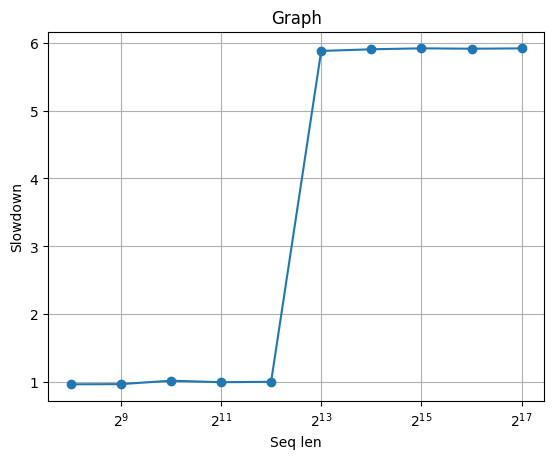

In [9]:
import matplotlib.pyplot as plt

# Data (x, y) pairs
# 1.017697
# 0.995605
# 0.964174
# 1.00135
# 0.966944
# 5.915788
# 5.902423
# 5.916561
# 5.910737
# 5.87773

    # (1024, 59.92367),
    # (2048, 111.843),
    # (256, 18.72233),
    # (4096, 217.765),
    # (512, 32.06),
    # (131072, 39944.88),
    # (16384, 5012.71),
    # (32768, 10009.58),
    # (65536, 19988.56),
    # (8192, 2517.747)
data = [
    (1024, 1.017697),
    (2048, 0.995605),
    (256, 0.964174),
    (4096, 1.00135),
    (512, 0.966944),
    (131072, 5.915788),
    (16384, 5.902423),
    (32768, 5.916561),
    (65536, 5.910737),
    (8192, 5.87773)
]

# Sort data by x values for a cleaner plot
data.sort(key=lambda pair: pair[0])

x_vals, y_vals = zip(*data)

plt.figure()
plt.plot(x_vals, y_vals, marker='o')
plt.xlabel('Seq len')
plt.ylabel('Slowdown')
plt.title('Graph')
plt.grid(True)
plt.xscale('log', base=2)  # Log scale for clearer spacing between powers of two
plt.show()


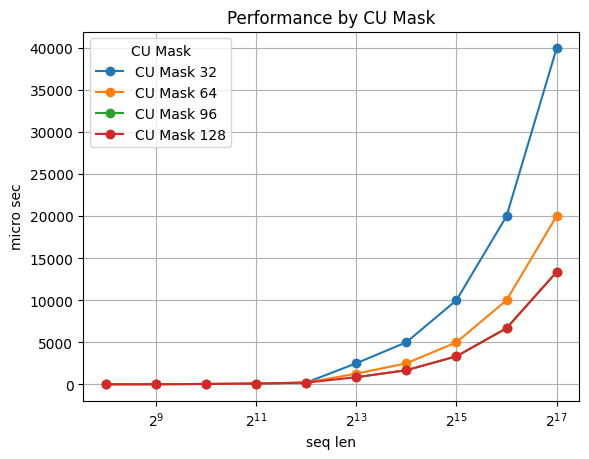

In [11]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Raw data as (size, cu_mask, value)
data = [
    (1024, 128, 59.13533),
    (1024, 32, 59.92367),
    (1024, 64, 58.98867),
    (2048, 128, 111.9627),
    (2048, 32, 111.843),
    (2048, 64, 112.6713),
    (256, 128, 19.48467),
    (256, 32, 18.72233),
    (256, 64, 19.645),
    (4096, 128, 217.351),
    (4096, 32, 217.765),
    (4096, 64, 218.206),
    (512, 128, 32.22033),
    (512, 32, 32.06),
    (512, 64, 32.38067),
    (131072, 128, 13362.19),
    (131072, 32, 39944.88),
    (131072, 64, 20013.35),
    (131072, 96, 13362.21),
    (16384, 128, 1699.101),
    (16384, 32, 5012.71),
    (16384, 64, 2511.694),
    (16384, 96, 1687.368),
    (32768, 128, 3345.829),
    (32768, 32, 10009.58),
    (32768, 64, 5010.598),
    (32768, 96, 3345.054),
    (65536, 128, 6686.366),
    (65536, 32, 19988.56),
    (65536, 64, 10006.6),
    (65536, 96, 6681.261),
    (8192, 128, 866.035),
    (8192, 32, 2517.747),
    (8192, 64, 1283.751),
    (8192, 96, 855.5977),
]

# Group data by cu_mask
grouped = defaultdict(list)
for size, cu_mask, val in data:
    grouped[cu_mask].append((size, val))

plt.figure()

# Plot each cu_mask as a separate line
for cu_mask, points in sorted(grouped.items()):  # sort for consistent legend order
    points.sort()  # sort by size
    x_vals, y_vals = zip(*points)
    plt.plot(x_vals, y_vals, marker='o', label=f"CU Mask {cu_mask}")

plt.xlabel('seq len')
plt.ylabel('micro sec')
plt.title('Performance by CU Mask')
plt.xscale('log', base=2)
plt.grid(True)
plt.legend(title='CU Mask')
plt.show()


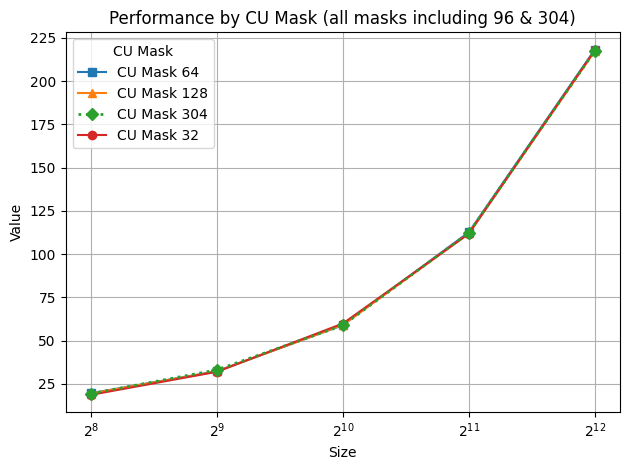

In [13]:
import matplotlib.pyplot as plt
from collections import defaultdict

# New raw data (size, cu_mask, value)
data = [
    (1024, 128, 59.13533), 
    (1024, 32, 59.92367), 
    (1024, 64, 58.98867), 
    (1024, 304, 58.88167),
    (2048, 128, 111.9627), (2048, 32, 111.843), (2048, 64, 112.6713), (2048, 304, 112.3367),
    (256, 128, 19.48467), (256, 32, 18.72233), (256, 64, 19.645), (256, 304, 19.418),
    (4096, 128, 217.351), (4096, 32, 217.765), (4096, 64, 218.206), (4096, 304, 217.4713),
    (512, 128, 32.22033), (512, 32, 32.06), (512, 64, 32.38067), (512, 304, 33.156),
    # (131072, 128, 13362.19), (131072, 32, 39944.88), (131072, 64, 20013.35), (131072, 96, 13362.21), (131072, 304, 6752.25),
    # (16384, 128, 1699.101), (16384, 32, 5012.71), (16384, 64, 2511.694), (16384, 96, 1687.368), (16384, 304, 849.263),
    # (32768, 128, 3345.829), (32768, 32, 10009.58), (32768, 64, 5010.598), (32768, 96, 3345.054), (32768, 304, 1691.791),
    # (65536, 128, 6686.366), (65536, 32, 19988.56), (65536, 64, 10006.6), (65536, 96, 6681.261), (65536, 304, 3381.738),
    # (8192, 128, 866.035), (8192, 32, 2517.747), (8192, 64, 1283.751), (8192, 96, 855.5977), (8192, 304, 428.3537),
]

# Group by cu_mask
grouped = defaultdict(list)
for size, cu_mask, val in data:
    grouped[cu_mask].append((size, val))

# Optional: provide distinct markers for clarity
markers = ['o', 's', '^', 'D', 'x', '*', 'v', 'P']
unique_masks = sorted(grouped.keys())
marker_map = {mask: markers[i % len(markers)] for i, mask in enumerate(unique_masks)}

# Special linestyles to make overlapping curves visible
linestyle_map = {96: '--', 304: ':'}  # dashed for 96, dotted for 304

plt.figure()

# Plot each mask; plot 32 last so others aren't hidden by its large values
for cu_mask in [m for m in unique_masks if m != 32] + [32]:
    points = sorted(grouped[cu_mask])  # sort by size
    x_vals, y_vals = zip(*points)
    plt.plot(
        x_vals,
        y_vals,
        marker=marker_map[cu_mask],
        linestyle=linestyle_map.get(cu_mask, '-'),
        linewidth=2 if cu_mask in (96, 304) else 1.5,
        label=f"CU Mask {cu_mask}",
        zorder=3 if cu_mask in (96, 304) else 2
    )

plt.xlabel('Size')
plt.ylabel('Value')
plt.title('Performance by CU Mask (all masks including 96 & 304)')
plt.xscale('log', base=2)
plt.grid(True)
plt.legend(title='CU Mask')
plt.tight_layout()
plt.show()
